Projeto de disciplina - Elasticsearch

Primeiramente uma base de dados será importada do site kaggle. Esta base possui os seguintes campos: "Unnamed: 0", "user", "game", "rating", "review". Optei por uma base de dados um pouco menor devido a estar tendo problemas de espaço no meu SSD e problemas de memória RAM (já estou providenciando uma solução). Entretanto, é uma base de dados interessante para a realização de recomendações.

Instalando o kaggle.

In [ ]:
!pip install -q kaggle
!rm -rf kaggle.json

Copiando o token contido no arquivo kaggle.json para a pasta kaggle.

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Download do dataset

In [ ]:
!kaggle datasets download -d trentenberam/metacritic-games-all-time

In [ ]:
!unzip metacritic-games-all-time.zip

In [1]:
import pandas as pd

metacritic_reviews = pd.read_csv("metacritic_reviews.csv")

In [2]:
metacritic_reviews

,Unnamed: 0,user,game,rating,review
0,1744,0,L.A. Noire,10,The most beautifully crafted game since Heavy ...
1,7386,1,Sekiro: Shadows Die Twice,10,"A departure from the Soulsborne formula, while..."
2,11593,2,XCOM 2,5,An RNG fest. A whole level will frequently be ...
3,9346,3,NieR: Automata,10,NieR: Automata is the biggest sleeper hit of 2...
4,10890,4,DOOM Eternal,10,the overly negative reviewers of this game get...
...,...,...,...,...,...
11706,1878,9973,It Takes Two,4,"Actually a great game in a creative setting, w..."
11707,7418,9974,Sekiro: Shadows Die Twice,10,This game is a perfect 10. I have spent upward...
11708,8254,9975,Super Mario Maker,7,Super Mario Maker is a fun tool for making you...
11709,11456,9976,Torchlight II,10,LOVE IT! Worth it since its only $20!! Don't b...


In [3]:
# As colunas que nos interessam são: "game", "rating", "review"

metacritic_reviews.drop(["Unnamed: 0", "user"], axis=1)

,game,rating,review
0,L.A. Noire,10,The most beautifully crafted game since Heavy ...
1,Sekiro: Shadows Die Twice,10,"A departure from the Soulsborne formula, while..."
2,XCOM 2,5,An RNG fest. A whole level will frequently be ...
3,NieR: Automata,10,NieR: Automata is the biggest sleeper hit of 2...
4,DOOM Eternal,10,the overly negative reviewers of this game get...
...,...,...,...
11706,It Takes Two,4,"Actually a great game in a creative setting, w..."
11707,Sekiro: Shadows Die Twice,10,This game is a perfect 10. I have spent upward...
11708,Super Mario Maker,7,Super Mario Maker is a fun tool for making you...
11709,Torchlight II,10,LOVE IT! Worth it since its only $20!! Don't b...


Instanciando o client do elastichsearch. Foi realizado sem a utilização de algum certificado. O banco de dados é iniciado com o comando sudo service elasticsearch start.

In [4]:
import elasticsearch

ES_URL = 'http://localhost:9200'
ES_USER = 'elastic'
ES_PASS = 'elastic123'

client = elasticsearch.Elasticsearch(ES_URL)

Realizando as configurações iniciais e o mapping, para que não seja utilizado o mapping dinâmico nos campos referenciados. Justificativas:

1º Char_filter: foram removidas eventuais tags html que por ventura estejam presentes nas reviews.
2º Tokenizer: o tokenizer padrão já atende a análise do campo de reviews de forma satisfatória.
3º Token filters: 
- asciifolding: necessário converter os vocabulários/símbolos não presentes na "Basic Latin Unicode" para esta base.
- lowercase: apesar de alguns nomes de jogos estarem presentes nas reviews, de forma geral
é interessante que tanto a inserção quanto as buscas referenciem nomes com o lowercase
evitando queries sem retornos apropriados ou mesmo que não retornem nada.
- replace_numbers: remove os número que no geral não adicionam informações relevantes.
- stop_en: remove as stopwords em inglês.
- stop_br: remove as stopwords em português brasileiro.
- stop_sp: remove as stopwords em espanhol.
- stop_custom: stopwords provenientes da biblioteca do nltk, também são referentes aos três idiomas mais utilizados.

In [5]:
import nltk

nltk.download("stopwords")

# As reviews não estão em um único idioma, portanto utilizarei as stopwords
# de 3 idiomas principais

nltk_stopwords_pt = nltk.corpus.stopwords.words("portuguese")
nltk_stopwords_en = nltk.corpus.stopwords.words("english")
nltk_stopwords_sp = nltk.corpus.stopwords.words("spanish")

nltk_stopwords = list(set(nltk_stopwords_pt + nltk_stopwords_en + nltk_stopwords_sp))

INDEX_NAME = "metacritic"

INDEX_MAPPING = {
    "settings": {
        "number_of_shards": 3,
        "analysis":{
            "analyzer": {
                "review_analyzer": {
                    "type": "custom",
                    "char_filter": ["html_strip"],
                    "tokenizer": "standard",               
                    "filter": ["asciifolding", "lowercase", "replace_numbers", "replace_puctuation",
                                "stop_en", "stop_br", "stop_sp", "stop_custom"]
                }
            },
            "filter": {
                "stop_en": {
                    "type": "stop",
                    "stopwords": "_english_",
                },
                "stop_br": {
                    "type": "stop",
                    "stopwords": "_brazilian_",
                },
                "stop_sp": {
                    "type": "stop",
                    "stopwords": "_spanish_",
                },
                "stop_custom": {
                    "type": "stop",
                    "stopwords": nltk_stopwords
                },
                "replace_numbers": {
                    "type": "pattern_replace",
                    "pattern": "([0-9]+)",
                    "replacement": ""
                },
                "replace_puctuation": {
                    "type": "pattern_replace",
                    "pattern": "[?|-|º|!|$|&|*|%|@|(|)|~|.|,|;|:|+|=|_|/|\|]",
                    "replacement": ""
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "Unnamed: 0": { "type": "integer"},
            "user": { "type": "integer"},
            "game": { 
                "type": "text",
                "fields": {
                    "keyword" : {
                        "type" : "keyword",
                        "ignore_above" : 256
                    }
                }
            },
            "rating": { 
                "type": "integer",
                "fields": {
                    "keyword" : {
                        "type" : "keyword",
                        "ignore_above" : 256
                    }
                }
            },
            "review": { 
                "type": "text",
                "analyzer": "review_analyzer",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    "min": 0.01,
                    "min_segment_size": 10,
                }
            }                
        }
    }
}


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/higoreller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Apagar o índice caso ele exista e criar um novo índice mapeado
if client.indices.exists(index=INDEX_NAME):
    client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, **INDEX_MAPPING)

/tmp/ipykernel_476/1993598049.py:2: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  if client.indices.exists(index=INDEX_NAME):
/tmp/ipykernel_476/1993598049.py:3: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  client.indices.delete(index=INDEX_NAME)
/tmp/ipykernel_476/1993598049.py:4: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  client.indices.crea

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'metacritic'})

Nesta etapa será realizada a conversão da base de dados de .csv para .ndjson para facilitar o processo de inserção. A primeira linha do arquivo .ndjson é removida, pois não é relevante como dado a ser indexado ("Unnamed: 0": "Unnamed: 0", "user": "user" etc...). Posteriormente a inserção sem a API bulk é utilizada (simples).

In [106]:
#Convertendo para ndjson para facilitar a indexação

import csv
import json

csvfile = open('metacritic_reviews.csv', 'r')
jsonfile = open('metacritic_reviews.ndjson', 'w')

# Definindo as chaves do dicionário iguais ao nosso dataset:
fieldnames = ("Unnamed: 0", "user", "game", "rating", "review")
reader = csv.DictReader(csvfile, fieldnames)

# Transformando em um iter para ignorar a primeira linha do documento, pois
# a primeira linha faz referência a própria chave ("game": "game"):
reader_iterator = iter(reader)
next(reader_iterator)


# Gerando o arquivo .ndjson
for row in reader_iterator:
    json.dump(row, jsonfile)
    jsonfile.write('\n')


# Removendo a última linha, pois não está no formato adequado para ser indexada:
with open('metacritic_reviews.ndjson','r') as fr:
    lines = fr.readlines()
    with open('metacritic_reviews.ndjson','w') as fw:
        for line in lines:
            if line != lines[len(lines)-1]:
                fw.write(line)

In [107]:
# Fazendo a inserção simples
import csv, json

with open('metacritic_reviews.ndjson','r') as fin:
    for line in fin:
        document = json.loads(line)
        client.index(index=INDEX_NAME, document=document)

/tmp/ipykernel_476/2066864247.py:7: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  client.index(index=INDEX_NAME, document=document)


Gerando duas nuvens de palavras representando os jogos que tiveram notas 9 e 10. Aqueles que aparecem maiores é porque receberam mais avaliações com essas notas. É um bom indicador de jogos, inclusive o jogo que está mais em destaque ("It takes two") foi eleito o jogo do ano em 2021.

In [108]:
QUERY = {
    'terms': {
        'rating': ['10']
    }
}

AGG = {
    'review': {
        'terms': {
            'field': 'game.keyword',
            'size': 100,
        }
    }
}

/tmp/ipykernel_476/958242010.py:4: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)


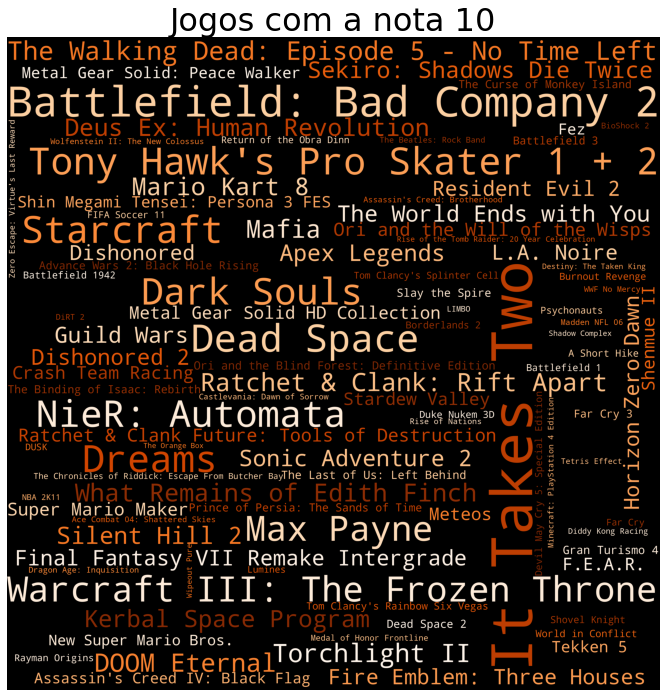

In [110]:
import wordcloud
import matplotlib.pyplot as plt

resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)

frequencies = {}

buckets = resp['aggregations']['review']['buckets']

for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(width=4000, height=4000, colormap="Oranges_r")
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(32, 12))
plt.axis("off")
plt.title('Jogos com a nota 10', fontsize=32)
plt.xticks()
plt.yticks()
ax.imshow(cloud)

In [111]:
QUERY = {
    'terms': {
        'rating': ['9']
    }
}

AGG = {
    'review': {
        'terms': {
            'field': 'game.keyword',
            'size': 100,
        }
    }
}

/tmp/ipykernel_476/766643232.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)


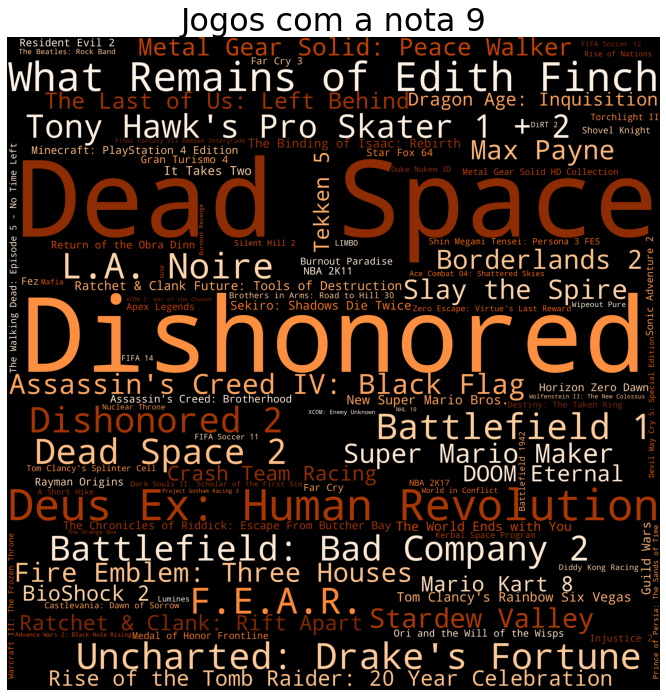

In [113]:
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)

frequencies = {}

buckets = resp['aggregations']['review']['buckets']

for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

cloud = wordcloud.WordCloud(width=4000, height=4000, colormap="Oranges_r")
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(32, 12))
plt.axis("off")
plt.title('Jogos com a nota 9', fontsize=32)
plt.xticks()
plt.yticks()
ax.imshow(cloud)

Nesta etapa serão buscados 10 jogos avaliados com a nota 10 e com a palavra "awesome" em sua review, para que 3 dos IDs sejam utilizados posteriormente na query more like this. Em produção esses IDs poderiam ser obtidos por meio do histórico do jogador ou mesmo através de um input de jogos que gostaria de jogar.

In [148]:
# Buscando 10 jogos com a pontuação 10 e com a palavra "awesome" em sua review
# utilizando uma query condicional.

query = {
    "bool" : {
        "must" : [{
            "match" : { 
                "rating" : "10"
            },
            "match" : { 
                "review" : "awesome"
            }
        }]    
    }
}

resp = client.search(index=INDEX_NAME, query=query, size=10)

/tmp/ipykernel_476/2348780457.py:17: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  resp = client.search(index=INDEX_NAME, query=query, size=10)


In [149]:
resp['hits']['hits']

[{'_index': 'metacritic',
  '_type': '_doc',
  '_id': 'M5uqsIEBheX6xxqXt_ay',
  '_score': 4.998889,
  '_source': {'Unnamed: 0': '7472',
   'user': '6461',
   'game': 'Madden NFL 06',
   'rating': '10',
   'review': ' Awesome, Simply Awesome.'}},
 {'_index': 'metacritic',
  '_type': '_doc',
  '_id': 'iZswsIEBheX6xxqXF73s',
  '_score': 4.979513,
  '_source': {'Unnamed: 0': '7472',
   'user': '6461',
   'game': 'Madden NFL 06',
   'rating': '10',
   'review': ' Awesome, Simply Awesome.'}},
 {'_index': 'metacritic',
  '_type': '_doc',
  '_id': 'O5swsIEBheX6xxqX3tBH',
  '_score': 4.9101114,
  '_source': {'Unnamed: 0': '11359',
   'user': '531',
   'game': 'The World Ends with You',
   'rating': '10',
   'review': 'Hard to get used to but when you do its awesome! Story is top notch and writing is awesome! Awesome combat system once you get used to are great!!!! 10/10 most own if you own a ds!\n!'}},
 {'_index': 'metacritic',
  '_type': '_doc',
  '_id': '5pswsIEBheX6xxqXLr86',
  '_score': 4.8

Aqui será realizada a busca a partir da query more like this. Adicionalmente aos IDs conseguidos anteriormente, serão adicionadas mais duas palavras que representam as preferências dos usuários, as palavras são "action" e "rpg". Os dois campos inferidos inicialmente foram o _score e o _id como é mostrado no "resp_df". Os 10 primeiros jogos retornados pela query more like this serão as recomendações que serão oferecidas aos usuários.

In [251]:
# Os jogos escolhidos foram:
# 'Apex Legends', 'Metal Gear Solid: Peace Walker', 'The World Ends with You'

QUERY = {
    'more_like_this': {
        'fields': ['game', 'review'],
        'like': [
            {
                '_index': INDEX_NAME,
                '_id': '5pswsIEBheX6xxqXLr86',
            },
            {
                '_index': INDEX_NAME,
                '_id': '6JyrsIEBheX6xxqXUgVJ',
            },
            {
                '_index': INDEX_NAME,
                '_id': 'gZsusIEBheX6xxqX_qJa',
            },
            "action", "rpg"
        ],
        'min_term_freq': 8,
        'max_query_terms': 12,
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, size=2000)

/tmp/ipykernel_476/1662021413.py:26: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  resp = client.search(index=INDEX_NAME, query=QUERY, size=2000)


In [252]:
# Inserindo o resultado da query em um Dataframe:

resp_df = pd.DataFrame({'_id': x['_id'], '_score': x['_score'], **x['_source']} for x in resp['hits']['hits'])

In [253]:
# Exibindo o Dataframe:

resp_df

,_id,_score,Unnamed: 0,user,game,rating,review
0,M5uqsIEBheX6xxqXt_ay,4.998889,7472,6461,Madden NFL 06,10,"Awesome, Simply Awesome."
1,iZswsIEBheX6xxqXF73s,4.979513,7472,6461,Madden NFL 06,10,"Awesome, Simply Awesome."
2,O5swsIEBheX6xxqX3tBH,4.910111,11359,531,The World Ends with You,10,Hard to get used to but when you do its awesom...
3,K5upsIEBheX6xxqXuNte,4.804163,11359,531,The World Ends with You,10,Hard to get used to but when you do its awesom...
4,qpsxsIEBheX6xxqXCdTS,4.791002,10166,1484,Warcraft III: The Frozen Throne,9,An awesome expansion to an awesome game. This ...
...,...,...,...,...,...,...,...
1851,EJuqsIEBheX6xxqXWOwk,0.669001,2413,4203,XCOM: Enemy Unknown,3,"Aaaah yes..XCOM. So, are you seriously telling..."
1852,lJuqsIEBheX6xxqXu_Yu,0.669001,6703,6548,Fallout 4,6,Score is based on the following Elements:\n A....
1853,ZpsvsIEBheX6xxqXsbMm,0.644755,2413,4203,XCOM: Enemy Unknown,3,"Aaaah yes..XCOM. So, are you seriously telling..."
1854,zpsvsIEBheX6xxqX_bqR,0.644755,209,5872,Dark Souls II: Scholar of the First Sin,9,I said if they had done something to fix Soul ...


In [264]:
# Contagem das ocorrências

resp_df['game'].value_counts()

Dishonored                          55
Battlefield: Bad Company 2          49
Deus Ex: Human Revolution           45
Assassin's Creed IV: Black Flag     39
Dead Space                          35
                                    ..
Asgard's Wrath                       2
Devil May Cry 5: Special Edition     2
Minecraft: PlayStation 4 Edition     2
Homeworld: Cataclysm                 2
Mass Effect 3                        2
Name: game, Length: 152, dtype: int64

In [263]:
# Transformando as somas das ocorrências para cada título em um dicionário:

recommended_games = dict(resp_df['game'].value_counts())

In [256]:
# Organizando o dicionário do maior número de ocorrências para o menor:

recommended_games = {k: v for k, v in sorted(recommended_games.items(), key=lambda item: item[1], reverse=True)}

In [257]:
# Transformando em uma lista para posteriormente exibir os dez jogos recomendados:

recommended_games =  list(recommended_games)

In [260]:
# Lista de recomendações

recommended_games[:10]

['Dishonored',
 'Battlefield: Bad Company 2',
 'Deus Ex: Human Revolution',
 "Assassin's Creed IV: Black Flag",
 'Dead Space',
 'Guild Wars',
 'Borderlands 2',
 'Max Payne',
 'Super Mario Maker',
 "Tony Hawk's Pro Skater 1 + 2"]